<a href="https://colab.research.google.com/github/reynancs/code-lab/blob/main/machine_learning_classification/Classificacao_com_Regressao_Logistica_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Logística para Classificação em Churn

**Objetivo:** criar um notebook de referência para regressão logística aplicada a problemas de churn de clientes, com explicações curtas sobre o que é, como aplicar, o que avaliar e como interpretar.
Esse material serve como apoio para case-studies e portfolio-projects.

---




### Sobre o dataset
Utilizaremos um conjunto de dados de telecomunicações para prever a **rotatividade de clientes**. Trata-se de um conjunto de dados históricos de clientes, em que cada linha representa um cliente. Os dados são relativamente fáceis de entender e você pode descobrir insights úteis imediatamente.
Normalmente, é mais barato manter clientes do que conquistar novos, portanto, **o foco desta análise é prever os clientes que permanecerão na empresa (churn=0).**

Este conjunto de dados fornece informações sobre as preferências dos clientes, serviços escolhidos, dados pessoais, etc., o que ajuda a prever a rotatividade de clientes.


### Sobre a variável alvo (churn)
A variável alvo churn indica se o cliente permaneceu (churn=0) ou abandonou a empresa (churn=1). Ela é binária e tem a seguinte interpretação:
- **Churn = 0**: Retido / Cliente Ativo - **clientes que permanecerão na empresa.**
- **Churn = 1**: Perdido / Cliente Cancelado - cliente cancelou o serviço, ou seja, **representa o risco de perda de clientes.**

Isso significa que, ao treinar modelos de classificação, o objetivo na maioria das vezes será **prever a probabilidade de churn = 1, que representa o risco de perda do cliente, entretanto, neste exemplo, usaremos churn = 0**

---

## Load Data from URL

Install and import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # mostrar todas as colunas dataframe pandas

In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"
df = pd.read_csv(url)
df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,20.75,0.0,15.25,35.7,42.00,211.45,125.0,1.0,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,0.00,0.0,0.00,0.0,288.80,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,0.00,0.0,0.00,0.0,157.05,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,45.00,50.1,23.25,64.9,239.55,1873.05,880.0,1.0,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,22.00,0.0,23.75,0.0,47.45,166.10,145.0,1.0,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


## Data Understanding

In [3]:
print('\nInfo:')
print(df.info())
print('\nDistribuição da Variável alvo:')
print(df['churn'].value_counts(normalize=True).round(3))


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null   

Vamos selecionar alguns atributos para a modelagem. Além disso, alteramos o tipo de dado de destino para um inteiro, conforme exigido pelo algoritmo scikit-learn:

### Verificando a média e variância das variáveis númericas


Percentuais:
churn
0.0    71.0
1.0    29.0
Name: count, dtype: float64


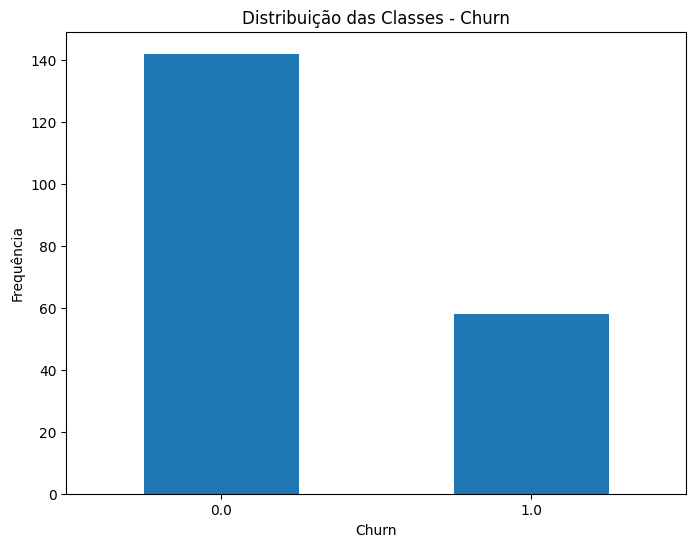

In [4]:
# Opção 1: Usando value_counts() com plot()
print(f"\nPercentuais:")
print(df['churn'].value_counts() / len(df) * 100)

df['churn'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Distribuição das Classes - Churn')
plt.xlabel('Churn')
plt.ylabel('Frequência')
plt.xticks(rotation=0)  # Para manter os rótulos horizontais
plt.show()

**Insights:**
- Variável Alvo desbalanceada, classe majoritária (churn=0)

In [5]:
df_stats = df.describe().round(2).T[['mean', 'std', 'min', 'max']]
df_stats.sort_values(by='std', ascending=False, inplace=True)
df_stats

,mean,std,min,max
cardten,650.66,941.47,0.00,7515.00
tollten,507.01,820.03,0.00,4938.60
longten,577.77,746.61,1.10,4333.00
income,75.13,128.43,9.00,1668.00
tenure,35.51,21.64,1.00,72.00
wiremon,12.22,21.63,0.00,109.70
equipmon,15.78,19.56,0.00,63.25
tollmon,13.24,15.64,0.00,68.50
cardmon,14.36,14.78,0.00,109.25
age,41.16,13.08,19.00,76.00


## Data Preprocessing

### 1. Feature Selection
>O objetivo é identificar e usar apenas o subconjunto mais relevante de características de entrada, descartando as irrelevantes ou redundantes.

Isso pode ajudar a:
- Simplificar o modelo.
- Reduzir o overfitting (especialmente com dados menores)
- Melhorar a interpretabilidade.

Técnicas como a **Lasso Regression** podem realizar seleção automática de características ao forçar os pesos de características menos importantes a zero.

In [6]:
#Subset
churn_df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'churn']]
churn_df['churn'].astype('int')
churn_df

,tenure,age,address,income,ed,employ,equip,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,0.0
...,...,...,...,...,...,...,...,...
195,55.0,44.0,24.0,83.0,1.0,23.0,0.0,0.0
196,34.0,23.0,3.0,24.0,1.0,7.0,0.0,0.0
197,6.0,32.0,10.0,47.0,1.0,10.0,0.0,0.0
198,24.0,30.0,0.0,25.0,4.0,5.0,0.0,1.0


Para modelar, os campos de entrada "X" e o campo de destino "y" precisam ser fixos.
Como o alvo a ser previsto é "churn", os dados deste campo serão armazenados na variável "y". Podemos usar qualquer combinação ou todos os campos restantes como entrada. Armazene esses valores na variável "X".

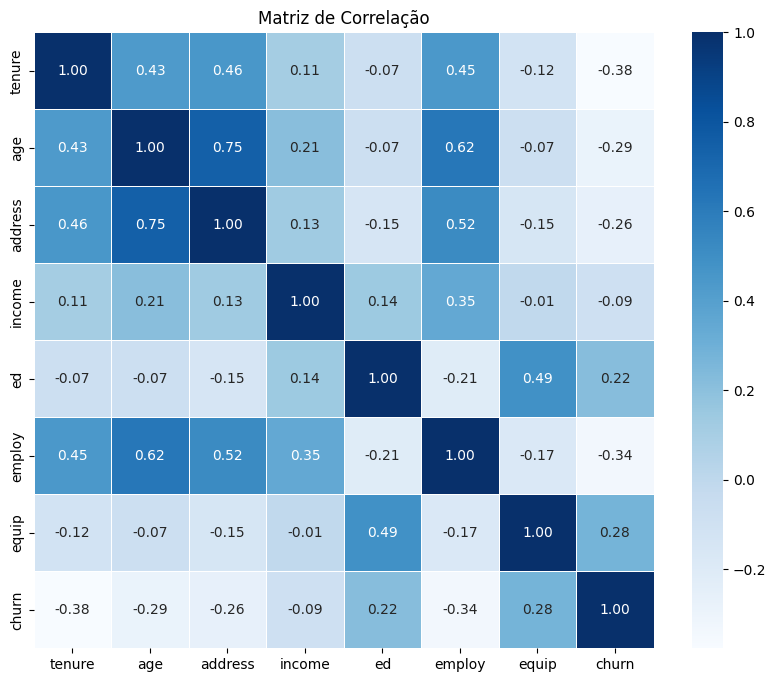

In [7]:
def plot_correlation_matrix(df):
    corr_df = df[df.select_dtypes(include=['float']).columns]  # Apenas atributos contínuos
    plt.figure(figsize=(10, 8))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

plot_correlation_matrix(churn_df)

In [8]:
# Split X vs y
X = churn_df.drop('churn', axis=1).values
y = churn_df['churn'].values

#Print o formato
print("Shape X Array: ", X.shape)
print("Shape y Array: ", y.shape)

Shape X Array:  (200, 7)
Shape y Array:  (200,)


### 2. Padronização (Z-score Standardization) dos dados (StandardScalar)

\\(z = \frac{x-u}{\sigma}\\)

Também é comum **padronizar ou normalizar** o conjunto de dados para que todos os recursos estejam na mesma escala. Isso ajuda o modelo a aprender mais rápido e melhora seu desempenho.

Podemos usar a função **StandardScalar()** da biblioteca Scikit-Learn. Esta função Transforma os dados para que tenham média 0 e desvio padrão 1.

ATENÇÃO:
- **Valores atípicos (outliers)** podem ter uma influência desproporcional nos modelos lineares, alterando significativamente os parâmetros aprendidos
- **StandardScaler()** ideal quando não tem limites definidos [0 á 1] e são sensíveis á escala como: Regressão, SVM, KNN e redes neurais.

| Tipo                    | Base estatística       | Sensível a outliers? | Intervalo comum         | Uso comum                                                              |
|-------------------------|------------------------|-----------------------|--------------------------|-------------------------------------------------------------------------|
| StandardScaler (Z-score) | Média e desvio padrão  | Sim                   | ≈ [-3, 3]                | Modelos lineares, SVM, Redes Neurais                                   |
| MinMaxScaler            | Mínimo e máximo         | Sim                   | [0, 1]                   | Imagens, redes neurais com Sigmoid/ReLU                                |
| RobustScaler            | Mediana e IQR           | Não                   | Depende da dispersão     | Dados com outliers, regressões robustas                                |
| Normalizer (L2/L1)      | Norma vetorial          | Sim                   | Escala da norma (1)      | Textos vetorizados, embeddings, regressão Lasso                        |


In [9]:
# Normalização das Variáveis Númericas
X_scaler = StandardScaler().fit(X).transform(X)
X_scaler

array([[-1.13518441, -0.62595491, -0.4588971 , ...,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, ..., -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , ..., -1.42318853,
        -0.92053635, -0.85972695],
       ...,
       [-1.36680743, -0.7026181 , -0.16283445, ..., -1.42318853,
        -0.02518185, -0.85972695],
       [-0.53296457, -0.85594447, -1.14970993, ...,  0.91629947,
        -0.58477841, -0.85972695],
       [ 1.18104577,  0.67731925,  0.42929083, ..., -0.6433592 ,
         1.31784991,  1.16316   ]])

In [10]:
X_norm = MinMaxScaler().fit(X).transform(X)
X_norm

array([[0.14084507, 0.24561404, 0.14583333, ..., 1.        , 0.11363636,
        0.        ],
       [0.45070423, 0.24561404, 0.25      , ..., 0.25      , 0.        ,
        0.        ],
       [0.30985915, 0.19298246, 0.1875    , ..., 0.        , 0.04545455,
        0.        ],
       ...,
       [0.07042254, 0.22807018, 0.20833333, ..., 0.        , 0.22727273,
        0.        ],
       [0.32394366, 0.19298246, 0.        , ..., 0.75      , 0.11363636,
        0.        ],
       [0.84507042, 0.54385965, 0.33333333, ..., 0.25      , 0.5       ,
        1.        ]])

## Modeling

Vamos construir o modelo usando LogisticRegression do pacote Scikit-learn e ajustar nosso modelo com o conjunto de dados de treinamento.


In [32]:
# Spliting the Data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=4) # stratify=y

print("Shape X_train: ", X_train.shape)
print("Shape X_test: ", X_test.shape)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Predict Class (y_pred)
y_pred = LR.predict(X_test)
print("Classe Preditora: ", y_pred[:10])

Shape X_train:  (160, 5)
Shape X_test:  (40, 5)
Classe Preditora:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Análise da Probabilidade de Previsão
Para entender essa previsão, também podemos **analisar a probabilidade de previsão** do ponto de dados do conjunto de dados de teste.

🔎 O que significa a saída?

O **predict_proba()** retorna uma matriz com as probabilidades de cada classe para cada observação do conjunto de teste.

- Linhas → cada linha corresponde a um **cliente/observação** no X_test.
- Colunas → cada coluna corresponde à **probabilidade prevista de cada classe da variável alvo (churn)**.

Neste caso a variável é binária:
- Coluna 0 → probabilidade do cliente ser classe 0 (churn=0, cliente permanece)
- Coluna 1 → probabilidade do cliente ser classe 1 (churn=1, cliente cancela)

📊 Como o modelo decide a classe (y_pred)?

O LogisticRegression usa por padrão um threshold de 0.5:
- Se prob(classe=1) ≥ 0.5 → prevê classe 1 (churn)
- Se prob(classe=1) < 0.5 → prevê classe 0 (não churn)

Por isso na linha 9 (73.8% para churn), o y_pred foi 1.

In [33]:
# Predict Class Probab (y_pred_prob)
y_pred_prob = LR.predict_proba(X_test)
print("\nProbabilidade das Classes Preditoras: \n", y_pred_prob[:10])


Probabilidade das Classes Preditoras: 
 [[0.51090568 0.48909432]
 [0.82253995 0.17746005]
 [0.62433309 0.37566691]
 [0.83557637 0.16442363]
 [0.71883667 0.28116333]
 [0.5218271  0.4781729 ]
 [0.58370687 0.41629313]
 [0.75347029 0.24652971]
 [0.11509056 0.88490944]
 [0.88309694 0.11690306]]


Gerando um dataframe com os resultados

In [34]:
#
df_results = pd.DataFrame({
    'Classe Real (y)':y_test,
    'Classe Prevista (y_pred)':y_pred,
    'Prob_Classe_0':y_pred_prob[:,0],
    'Prob_Classe_1':y_pred_prob[:,1]
    })

df_results.head(10)

,Classe Real (y),Classe Prevista (y_pred),Prob_Classe_0,Prob_Classe_1
0,0.0,0.0,0.510906,0.489094
1,0.0,0.0,0.822540,0.177460
2,1.0,0.0,0.624333,0.375667
3,0.0,0.0,0.835576,0.164424
4,1.0,0.0,0.718837,0.281163
5,1.0,0.0,0.521827,0.478173
6,1.0,0.0,0.583707,0.416293
7,0.0,0.0,0.753470,0.246530
8,1.0,1.0,0.115091,0.884909
9,1.0,0.0,0.883097,0.116903


In [35]:
y_pred_custom = (y_pred_prob[:,1] >= 0.4).astype(int)
y_pred_custom

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

Assim, quando o modelo erra, significa que:

- A probabilidade prevista foi para o lado errado (ex.: 0.48 vs 0.52 → muito próximo, mas o modelo escolheu o outro lado).
- O modelo não capturou bem o padrão (por limitações de features ou complexidade).
- Pode haver ruído nos dados (o cliente parecia que ia ficar, mas na prática cancelou, ou vice-versa).

✅ Como interpretar

Essas diferenças são os erros do modelo, e você deve:
- **Quantificar** → usando métricas como accuracy, precision, recall, f1-score, matriz de confusão.
- **Entender** → olhar os clientes em que o modelo erra, pois eles mostram padrões sutis (ou outliers).
- **Melhorar** → ajustando o threshold (por exemplo, usar 0.4 ao invés de 0.5 se quiser reduzir falsos negativos de churn).

## Evaluation

Uma vez geradas as previsões, torna-se prudente avaliar o desempenho do modelo na previsão da variável-alvo. Vamos avaliar o valor da perda logarítmica.

### Análise de Coeficientes

**🔎 O que significam os coeficientes na Regressão Logística?**

1. Sinal (positivo ou negativo):
  - **Coeficiente positivo (+)**: quanto maior a feature, **maior a chance de o cliente cancelar (churn=1)**,ou seja, **quanto maior, mais churn (classe=1).**

  - **Coeficiente negativo (–)**: quanto maior a feature, **menor a chance de churn (classe=0)**, ou seja, **cliente tende a permanecer**.

2. Magnitude (valor absoluto):
  - Valores mais distantes de zero: **indicam maior impacto no modelo**.
  - Valores próximos de zero: têm pouca relevância para a decisão.
---

**✅ Como identificar a importância das features**

1. Pelo valor absoluto dos coeficientes:
  - Ordene os coeficientes por |coef| → os **maiores são os mais importantes**.

2. Com métodos adicionais (boa prática):
  - coef_ dá a direção do efeito.
  - Para importância relativa, pode-se usar:
    - **Permutation Importance**
    - **SHAP values**
    - **Feature Importance normalizado**

Text(0, 0.5, 'Valores dos Coeficientes')

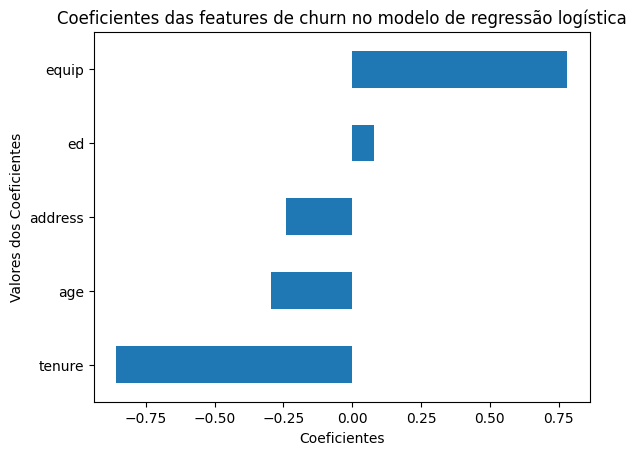

In [36]:
coeficients = pd.Series(LR.coef_[0], index=churn_df.columns[:-1])
coeficients.sort_values().plot(kind='barh')

plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")


**INSIGHTS:**
- **Fatores mais relevantes:**
    - `equip` (~ +0.8) → Quanto mais equipamentos/serviços o cliente possui, maior a chance de churn. (**Pode indicar insatisfação mesmo consumindo mais serviços**), ou seja, **quanto maior, mais churn (classe=1).**

    - `tenure` (~ –0.8) → Clientes com mais tempo de contrato têm menor chance de churn.(**Clientes fiéis tendem a permanecer**), ou seja, **quanto maior, menos churn (classe=0).**

- **Fatores menos relevantes:**
  - `employ`, `age`, `address` (entre –0.2 e 0) → Pequeno efeito protetivo contra churn: **clientes mais velhos, empregados ou mais tempo no mesmo endereço tendem a ficar.**
  - `income`, `ed` (próximos de 0) → Praticamente não influenciam o modelo (baixo impacto).

---

### Log Loss (Binary Cross entropy loss)
A perda logarítmica (perda logarítmica), também conhecida como perda de entropia cruzada binária(Binary Cross entropy loss), é usado como métrica de avaliação (cost function) para **medir o quão bem as probabilidades previstas correspondem às classes reais.**  Ela não penaliza apenas as respostas erradas, mas leva em conta o nível de confiança do modelo nessas respostas.

O princípio fundamental é:
A Log Loss **penaliza exponencialmente as previsões que estão muito confiantes e erradas.**


**Fórmula:**

\\( Log\_loss = -\frac{1}{N} \sum_{i=1}^{N} \big[ y_i \cdot \log(\hat{p}_i) + (1 - y_i) \cdot \log(1 - \hat{p}_i) \big] \\)

onde:
- \\([ y_i \cdot \log(\hat{p}_i)\big]\\) -> Probabilidade Classe = 1
- \\([ y_i (1 - y_i) \cdot \log(1 - \hat{p}_i) \big] \\) -> Probabilidade Classe = 0
---

**📖 Interpretação Intuitiva:**
- O Log-Loss **mede o erro de classificação probabilística**.
- Ele avalia quão próximas as probabilidades preditas \\( \hat{p}_i \\) estão dos rótulos reais \\( y_i \\).
- **Quanto menor o valor, melhor o modelo** (0 = perfeito).

🔎 **Casos importantes:**
- Se o modelo prevê \\( \hat{p}_i = 0.9 \\) e o rótulo real é \\( y_i = 1 \\), **o erro será pequeno (boa previsão) -> Confiante e Correto**
- Se prevê \\( \hat{p}_i = 0.9 \\) mas o rótulo real é \\( y_i = 0 \\), **o erro será muito alto (penalização severa) -> Confiante e Incorreto**
- Previsões próximas de 0.5 são incertas → **penalização moderada -> Menos Confiante e Incorreto**

⚖️ **Em resumo:**
- Confiança Correta → recompensa (baixo log-loss).
- Confiança Incorreta → punição forte (alto log-loss).

Portanto, **quando o modelo prevê altas probabilidades para a classe incorreta, ele está sendo "teimoso" no erro.**

In [37]:
log_loss(y_test, y_pred_prob)

0.6065139542232707

📌 Interpretação:
- Log Loss = 0.6258 indica que seu modelo tem desempenho mediano/razoável, ou seja, significa que há uma quantidade considerável de previsões erradas com alta confiança, mas há espaço significativo para melhoria.
- Meta realista: Tente chegar a um log_loss < 0.5 para ter um modelo realmente útil no negócio!
---

🔍 Possíveis causas do resultado moderado:
- Desbalanceamento de classes (muito mais clientes que permanecem vs. saem)
- Features insuficientes ou pouco informativas
- Modelo subajustado (underfitting)
- Necessidade de feature engineering
- Hiperparâmetros não otimizados

💡 Sugestões para melhorar:
- Balanceamento de dados: Use SMOTE, class_weight, ou undersample
- Feature engineering: Crie novas variáveis relevantes
- Otimização de hiperparâmetros: GridSearch ou RandomSearch
- Modelos mais complexos: Random Forest, XGBoost, etc.
- Análise de features: Veja quais são mais importantes


---
**Insights:**
- Issue 01: Classes Desbalanceadas
  - O modelo está errando sistematicamente nos clientes da classe 1 (churn), porque ele tende a prever classe 0 (que é majoritária, 71%).
  - Isso indica mais viés causado pelo desbalanceamento das classes do que overfitting.
  - Ação: Foi adicionando o atributo **class_weight='balanced'** no modelo e houve uma pequena melhora Log Loss (perda menor);
- Issue 02: Normalização (Min-Max) ou Padronização (StandardScaler)?
  - Realizado o teste com normalização -> resultado piorou.
  - Conclusão: Como Regressão Logistica trata-se de um modelo Linear, o mais indicado é a padronização dos dados

---

## Exercicios

#### a. Suponhamos que adicionamos o atributo `callcard` ao conjunto original de recursos de entrada. Qual será o valor da perda de logaritmo neste caso?

LOG LOSS: 0.5503846197055096


Text(0, 0.5, 'Valores dos Coeficientes')

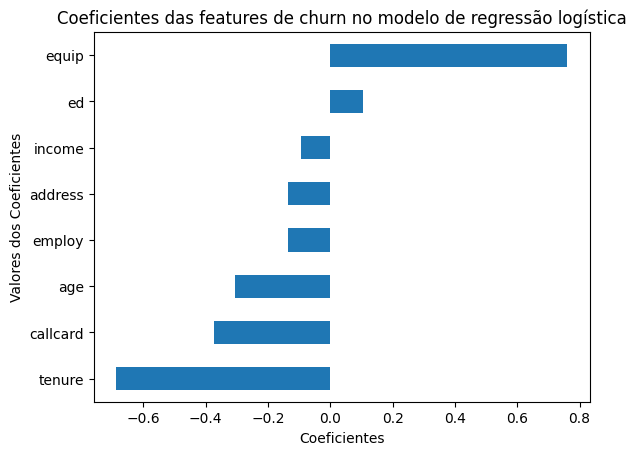

In [38]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard']])

# Aplica a Normalização dos Dados
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=4)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))


coeficients = pd.Series(data=LR.coef_[0], index=churn_df.columns[:-1])
coeficients.sort_values().plot(kind='barh')

plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")

### b. Suponhamos que adicionamos o atributo  "wireless" ao conjunto original das variáveis de entrada. Qual será o valor da perda de logaritmo neste caso?

LOG LOSS: 0.6907425743827962


Text(0, 0.5, 'Valores dos Coeficientes')

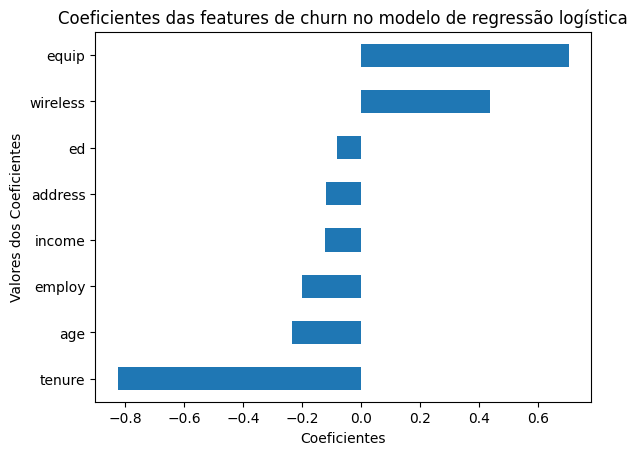

In [24]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'wireless', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'wireless']])

# Aplica a Normalização dos Dados
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=4)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))

coeficients = pd.Series(data=LR.coef_[0], index=churn_df.columns[:-1])
coeficients.sort_values().plot(kind='barh')

plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")

### c. O que acontece com o valor da perda de log se adicionarmos "callcard" e "wireless" aos recursos de entrada?

LOG LOSS: 0.7701064272364262


Text(0, 0.5, 'Valores dos Coeficientes')

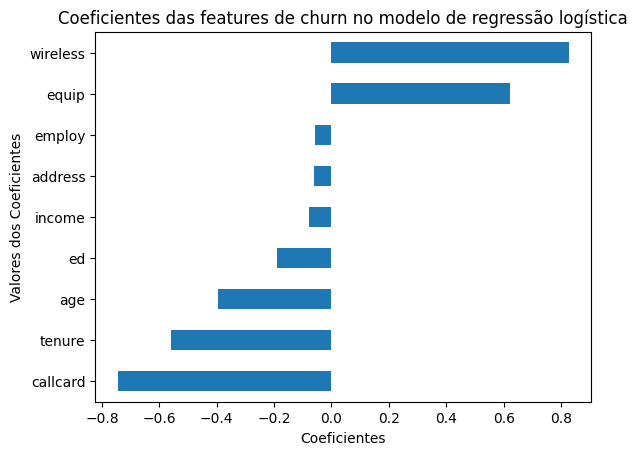

In [25]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard','wireless', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard','wireless']])

# Aplica a Normalização dos Dados
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=4)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))

coeficients = pd.Series(data=LR.coef_[0], index=churn_df.columns[:-1])
coeficients.sort_values().plot(kind='barh')

plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")

### d. O que acontece com a perda de log se removermos o atributo 'equip' do conjunto original de recursos de entrada?

LOG LOSS: 0.46483271129639653


Text(0, 0.5, 'Valores dos Coeficientes')

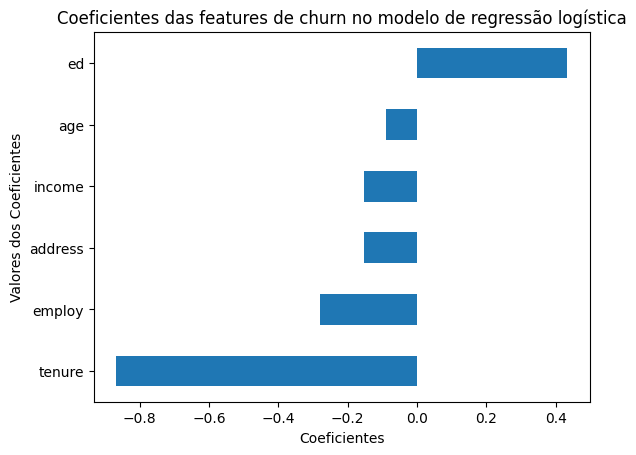

In [26]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(df[['tenure', 'age', 'address', 'income', 'ed', 'employ']])

# Aplica a Normalização dos Dados - StandardScaler()
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste -
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=4)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))

# Chart
coeficients = pd.Series(data=LR.coef_[0], index=churn_df.columns[:-1] )
coeficients.sort_values().plot(kind='barh')
plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")


### e. O que acontece com a perda de log se removermos os atributos 'income' e 'employ' do conjunto original de recursos de entrada?

LOG LOSS: 0.6065139542232707


Text(0, 0.5, 'Valores dos Coeficientes')

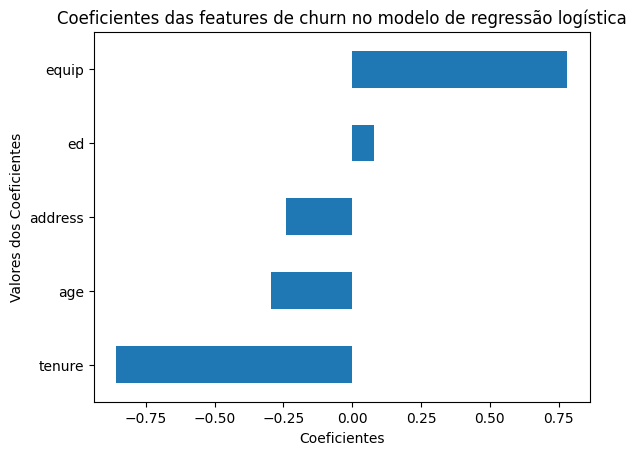

In [27]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'ed', 'equip', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(df[['tenure', 'age', 'address', 'ed', 'equip']])

# Aplica a Normalização dos Dados - StandardScaler()
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste -
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=4)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))

# Chart
coeficients = pd.Series(data=LR.coef_[0], index=churn_df.columns[:-1] )
coeficients.sort_values().plot(kind='barh')
plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")

LOG LOSS: 0.6065139542232707
Coeficientes:  [-0.85651286 -0.29501813 -0.239138    0.07822239  0.78169182]
Intercepto:  -0.49213229353453625
Features:  Index(['tenure', 'age', 'address', 'ed', 'equip'], dtype='object')


Text(0, 0.5, 'Valores dos Coeficientes')

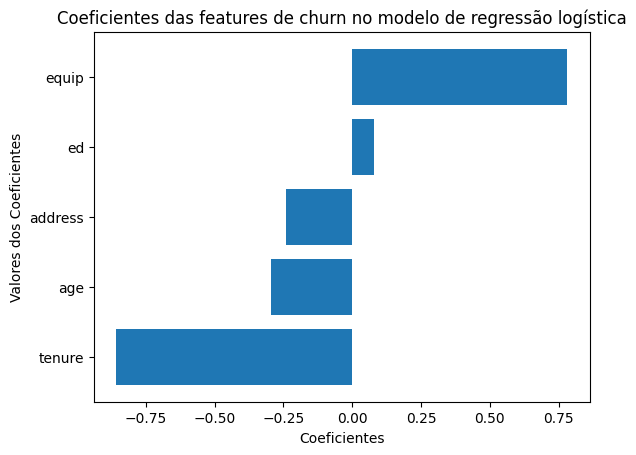

In [28]:
# Seleciona os atributos
churn_df = df[['tenure', 'age', 'address', 'ed', 'equip', 'churn']]
churn_df['churn'].astype('int')

# Converte os atributos para formato numpy
X = np.asarray(df[['tenure', 'age', 'address', 'ed', 'equip']])

# Aplica a Normalização dos Dados - StandardScaler()
X_scaler = StandardScaler().fit(X).transform(X)

# Aplica o split nos dados de treino e teste -
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=42)

# MOdel Object
LR = LogisticRegression(class_weight='balanced') # class_weight='balanced'

# Model.fit() - Training Data
LR.fit(X_train, y_train)

# Calcula o valor preditor (yhat)
yhat = LR.predict(X_test)

# Calcula a probabilidade das classes [0;1]
yhat_prob = LR.predict_proba(X_test)

# Calcula a perda Loss
print("LOG LOSS:",log_loss(y_test, yhat_prob))


# Derive coefficients
coeficients = LR.coef_[0]
intercept = LR.intercept_[0]
feature_names = churn_df.columns[:-1]
print("Coeficientes: ", coeficients)
print("Intercepto: ", intercept)
print("Features: ", feature_names)

# Plot Coefficients
plt.barh(feature_names, coeficients)
plt.title("Coeficientes das features de churn no modelo de regressão logística")
plt.xlabel("Coeficientes")
plt.ylabel("Valores dos Coeficientes")